Heston Calibrator Demo

This notebook demonstrates the QuantLib Heston calibrator with:
1. Market data fetching
2. Heston model calibration using the working calibrator
3. Implied volatility surface reconstruction
4. Market vs Model IV surface comparison
5. Comprehensive visualization and analysis

Based on the debugged and working `quantlib_heston_calibrator.py`.

## Setup and Configuration

In [19]:
# Import required libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import QuantLib as ql
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add project paths
project_root = r'C:\Users\Ao Shen\Desktop\mfin research\src'
heston_path = r'C:\Users\Ao Shen\Desktop\mfin research\src\heston_calib'

for path in [project_root, heston_path]:
    if path not in sys.path:
        sys.path.insert(0, path)

# Import custom modules
from market_data_fetcher import MarketDataFetcher
from quantlib_heston_calibrator import QuantLibHestonCalibrator

print("Libraries imported successfully")
print(f"QuantLib version: {ql.__version__}")

Libraries imported successfully
QuantLib version: 1.38


In [20]:
# Configuration
TICKER = 'NVDA'
EXPIRY_LIST = [ '1M', '3M']  # Short to medium term expiries for better comparison
ATM_RANGE = 0.15  # ±15% around spot for better quality
RISK_FREE_RATE = 0.015  # 1.5% risk-free rate
DIVIDEND_YIELD = 0.0    # No dividend for NVDA

print("Configuration:")
print(f"  Ticker: {TICKER}")
print(f"  Expiry list: {EXPIRY_LIST}")
print(f"  ATM range: ±{ATM_RANGE*100:.0f}%")
print(f"  Risk-free rate: {RISK_FREE_RATE:.1%}")
print(f"  Dividend yield: {DIVIDEND_YIELD:.1%}")

Configuration:
  Ticker: NVDA
  Expiry list: ['1M', '3M']
  ATM range: ±15%
  Risk-free rate: 1.5%
  Dividend yield: 0.0%


## Market Data Fetching

In [21]:
# Fetch market data using the working fetcher
print("Fetching market data...")

fetcher = MarketDataFetcher(
    ticker=TICKER, 
    expiry_list=EXPIRY_LIST, 
    atm_range=ATM_RANGE
)

market_data = fetcher.prepare_market_data()
spot_price = fetcher.get_spot_price()

print(f"\nMarket data fetched:")
print(f"  Spot price: ${spot_price:.2f}")
print(f"  Total options: {len(market_data)}")
print(f"  Calls: {len(market_data[market_data['OptionType'] == 'call'])}")
print(f"  Puts: {len(market_data[market_data['OptionType'] == 'put'])}")
print(f"  DTE range: {market_data['DaysToExpiry'].min()} to {market_data['DaysToExpiry'].max()} days")
print(f"  Strike range: ${market_data['Strike'].min():.0f} to ${market_data['Strike'].max():.0f}")

# Show sample data
print("\nSample data:")
display(market_data.head())

Fetching market data...
Target 2025-08-12: Found 2025-08-15 (2 days difference)
Target 2025-10-11: Found 2025-10-17 (5 days difference)
Using specific expiry dates: ['2025-08-15', '2025-10-17']
Preparing market data for NVDA
Time range: 2025-07-13 to 2025-10-11
ATM range: ±15.0%
Fetching option data for NVDA...
Fetching specific expiries: ['2025-08-15', '2025-10-17']
  Fetched 101 contracts for 2025-08-15
  Fetched 101 contracts for 2025-10-17
Fetched 202 raw option contracts
Applying quality filters...
Quality filters removed 44 contracts
Applying ATM filter...
ATM filter (±15.0% around $164.92) kept 36 of 158 contracts
Strike range: $145.00 to $185.00
Final dataset: 36 contracts across 2 maturities
DTE range: 33 to 96 days

Market data fetched:
  Spot price: $164.92
  Total options: 36
  Calls: 18
  Puts: 18
  DTE range: 33 to 96 days
  Strike range: $145 to $185

Sample data:


,OptionType,Strike,DaysToExpiry,MarketPrice
28,call,145.0,33,22.125
29,call,150.0,33,17.900
30,call,155.0,33,14.050
31,call,160.0,33,10.550
32,call,165.0,33,7.625


## Heston Model Calibration

In [22]:
# Initialize the QuantLib Heston calibrator
print("Initializing Heston calibrator...")

calibrator = QuantLibHestonCalibrator(
    r=RISK_FREE_RATE, 
    q=DIVIDEND_YIELD
)

print(f"Calibrator initialized with evaluation date: {calibrator.evaluation_date}")

Initializing Heston calibrator...
Calibrator initialized with evaluation date: July 13th, 2025


In [23]:
# Perform Heston calibration with multi-start
print("Starting Heston calibration with multi-start...")
print("This may take a moment...\n")

heston_model, calibration_info = calibrator.calibrate(
    spot=spot_price,
    market_data=market_data,
    multi_start=True
)

print("\n" + "="*60)
calibrator.print_results(calibration_info)
print("="*60)

Starting Heston calibration with multi-start...
This may take a moment...

Starting Heston calibration for 36 options using implied volatility...
Initial params: v0=0.150, κ=1.5, θ=0.120, σ=0.3, ρ=-0.7
Debug counts: {'total': 36, 'basic_filter': 0, 'moneyness_filter': 0, 'price_filter': 0, 'iv_filter': 0, 'success': 36}
Created 36 helpers from 36 options using implied volatilities
  Attempt 1: avg error = 0.100 (implied vol)
  Attempt 2: avg error = 0.100 (implied vol)
  Attempt 3: avg error = 0.100 (implied vol)
Multi-start calibration completed! Best avg error: 0.100 (implied vol)

HESTON CALIBRATION RESULTS
Method:          Implied Volatility (HestonModelHelper)
Multi-start:     ✓ (3 attempts)
Initial vol:     58.5%
Long-term vol:   70.7%
Mean reversion:  2.4
Vol-of-vol:      1.0%
Correlation:     0.13
Avg error:       0.100 (implied vol)
Options used:    36
Feller condition: ✓


## IV Surface Reconstruction

In [24]:
# Reconstruct implied volatility surface
print("Reconstructing implied volatility surfaces...")

if not calibration_info['success']:
    raise ValueError("Calibration failed - cannot reconstruct IV surface")

# Create Heston pricing engine
heston_engine = ql.AnalyticHestonEngine(heston_model)

# Prepare comparison data
iv_comparison_results = []

print(f"Processing {len(market_data)} options for IV comparison...")

for idx, (_, row) in enumerate(market_data.iterrows()):
    try:
        # Calculate market implied volatility
        time_to_expiry = row.DaysToExpiry / 252.0
        market_iv = calibrator._calculate_implied_vol(
            row.MarketPrice, spot_price, row.Strike, 
            time_to_expiry, row.OptionType
        )
        
        # Skip if market IV is unreasonable
        if market_iv < 0.05 or market_iv > 2.0:
            continue
            
        # Create option for Heston pricing
        is_call = row.OptionType.lower() == 'call'
        option_type = ql.Option.Call if is_call else ql.Option.Put
        
        period = ql.Period(int(row.DaysToExpiry), ql.Days)
        expiry_date = calibrator.evaluation_date + period
        exercise = ql.EuropeanExercise(expiry_date)
        payoff = ql.PlainVanillaPayoff(option_type, float(row.Strike))
        option = ql.VanillaOption(payoff, exercise)
        option.setPricingEngine(heston_engine)
        
        # Get Heston price and calculate implied volatility
        heston_price = option.NPV()
        
        if heston_price > 0.01:  # Only if price is meaningful
            heston_iv = calibrator._calculate_implied_vol(
                heston_price, spot_price, row.Strike, 
                time_to_expiry, row.OptionType
            )
            
            # Store comparison result
            iv_comparison_results.append({
                'Strike': row.Strike,
                'DaysToExpiry': row.DaysToExpiry,
                'OptionType': row.OptionType,
                'TimeToExpiry': time_to_expiry,
                'Moneyness': spot_price / row.Strike,
                'MarketPrice': row.MarketPrice,
                'HestonPrice': heston_price,
                'MarketIV': market_iv,
                'HestonIV': heston_iv,
                'IVDiff': heston_iv - market_iv,
                'IVDiffPct': (heston_iv - market_iv) / market_iv * 100,
                'PriceDiff': heston_price - row.MarketPrice,
                'PriceDiffPct': (heston_price - row.MarketPrice) / row.MarketPrice * 100,
                'AbsIVError': abs(heston_iv - market_iv)
            })
            
    except Exception as e:
        continue

# Convert to DataFrame
iv_comparison_df = pd.DataFrame(iv_comparison_results)

print(f"\nIV SURFACE RECONSTRUCTION COMPLETE")
print("=" * 50)
print(f"Valid comparisons: {len(iv_comparison_df)}")
print(f"Success rate: {len(iv_comparison_df)/len(market_data)*100:.1f}%")

if len(iv_comparison_df) > 0:
    print(f"\nMARKET vs HESTON COMPARISON:")
    print(f"  Market IV range: {iv_comparison_df['MarketIV'].min():.1%} to {iv_comparison_df['MarketIV'].max():.1%}")
    print(f"  Heston IV range: {iv_comparison_df['HestonIV'].min():.1%} to {iv_comparison_df['HestonIV'].max():.1%}")
    
    # Key error metrics
    mean_iv_error = iv_comparison_df['IVDiff'].mean()
    mean_abs_iv_error = iv_comparison_df['AbsIVError'].mean()
    rmse_iv = np.sqrt((iv_comparison_df['IVDiff']**2).mean())
    correlation = iv_comparison_df['MarketIV'].corr(iv_comparison_df['HestonIV'])
    
    print(f"\nERROR ANALYSIS:")
    print(f"  Mean IV error: {mean_iv_error:+.1%} (Heston vs Market)")
    print(f"  Mean absolute IV error: {mean_abs_iv_error:.1%}")
    print(f"  RMSE (IV): {rmse_iv:.1%}")
    print(f"  Correlation: {correlation:.3f}")
    
    # Interpretation
    if mean_iv_error > 0.01:
        print(f"  → Heston model overestimates volatility on average")
    elif mean_iv_error < -0.01:
        print(f"  → Heston model underestimates volatility on average")
    else:
        print(f"  → Heston model shows minimal bias")
    
    if correlation > 0.9:
        print(f"  → Excellent correlation between market and model")
    elif correlation > 0.7:
        print(f"  → Good correlation between market and model")
    else:
        print(f"  → Moderate correlation - model may need refinement")
    
    # Show sample comparisons with better formatting
    print(f"\nSAMPLE COMPARISONS (first 10 options):")
    sample_cols = ['OptionType', 'DaysToExpiry', 'Strike', 'MarketIV', 'HestonIV', 'IVDiff']
    sample_df = iv_comparison_df[sample_cols].head(10).copy()
    sample_df['MarketIV'] = sample_df['MarketIV'].apply(lambda x: f"{x:.1%}")
    sample_df['HestonIV'] = sample_df['HestonIV'].apply(lambda x: f"{x:.1%}")
    sample_df['IVDiff'] = sample_df['IVDiff'].apply(lambda x: f"{x:+.1%}")
    sample_df.columns = ['Type', 'DTE', 'Strike', 'Market IV', 'Heston IV', 'Difference']
    display(sample_df)
    
else:
    print("No valid IV comparisons available")

Reconstructing implied volatility surfaces...
Processing 36 options for IV comparison...

IV SURFACE RECONSTRUCTION COMPLETE
Valid comparisons: 36
Success rate: 100.0%

MARKET vs HESTON COMPARISON:
  Market IV range: 32.8% to 47.0%
  Heston IV range: 33.7% to 43.7%

ERROR ANALYSIS:
  Mean IV error: -1.0% (Heston vs Market)
  Mean absolute IV error: 1.7%
  RMSE (IV): 2.1%
  Correlation: 0.860
  → Heston model shows minimal bias
  → Good correlation between market and model

SAMPLE COMPARISONS (first 10 options):


,Type,DTE,Strike,Market IV,Heston IV,Difference
0,call,33,145.0,46.2%,43.6%,-2.5%
1,call,33,150.0,43.6%,41.8%,-1.8%
2,call,33,155.0,41.7%,40.0%,-1.7%
3,call,33,160.0,39.6%,38.2%,-1.4%
4,call,33,165.0,38.2%,36.6%,-1.6%
5,call,33,170.0,37.1%,35.3%,-1.9%
6,call,33,175.0,36.2%,34.3%,-1.9%
7,call,33,180.0,35.8%,33.8%,-2.0%
8,call,33,185.0,35.7%,33.7%,-2.1%
9,put,33,145.0,42.0%,43.6%,+1.6%


## Visualization and Analysis

Creating enhanced visualization dashboard...


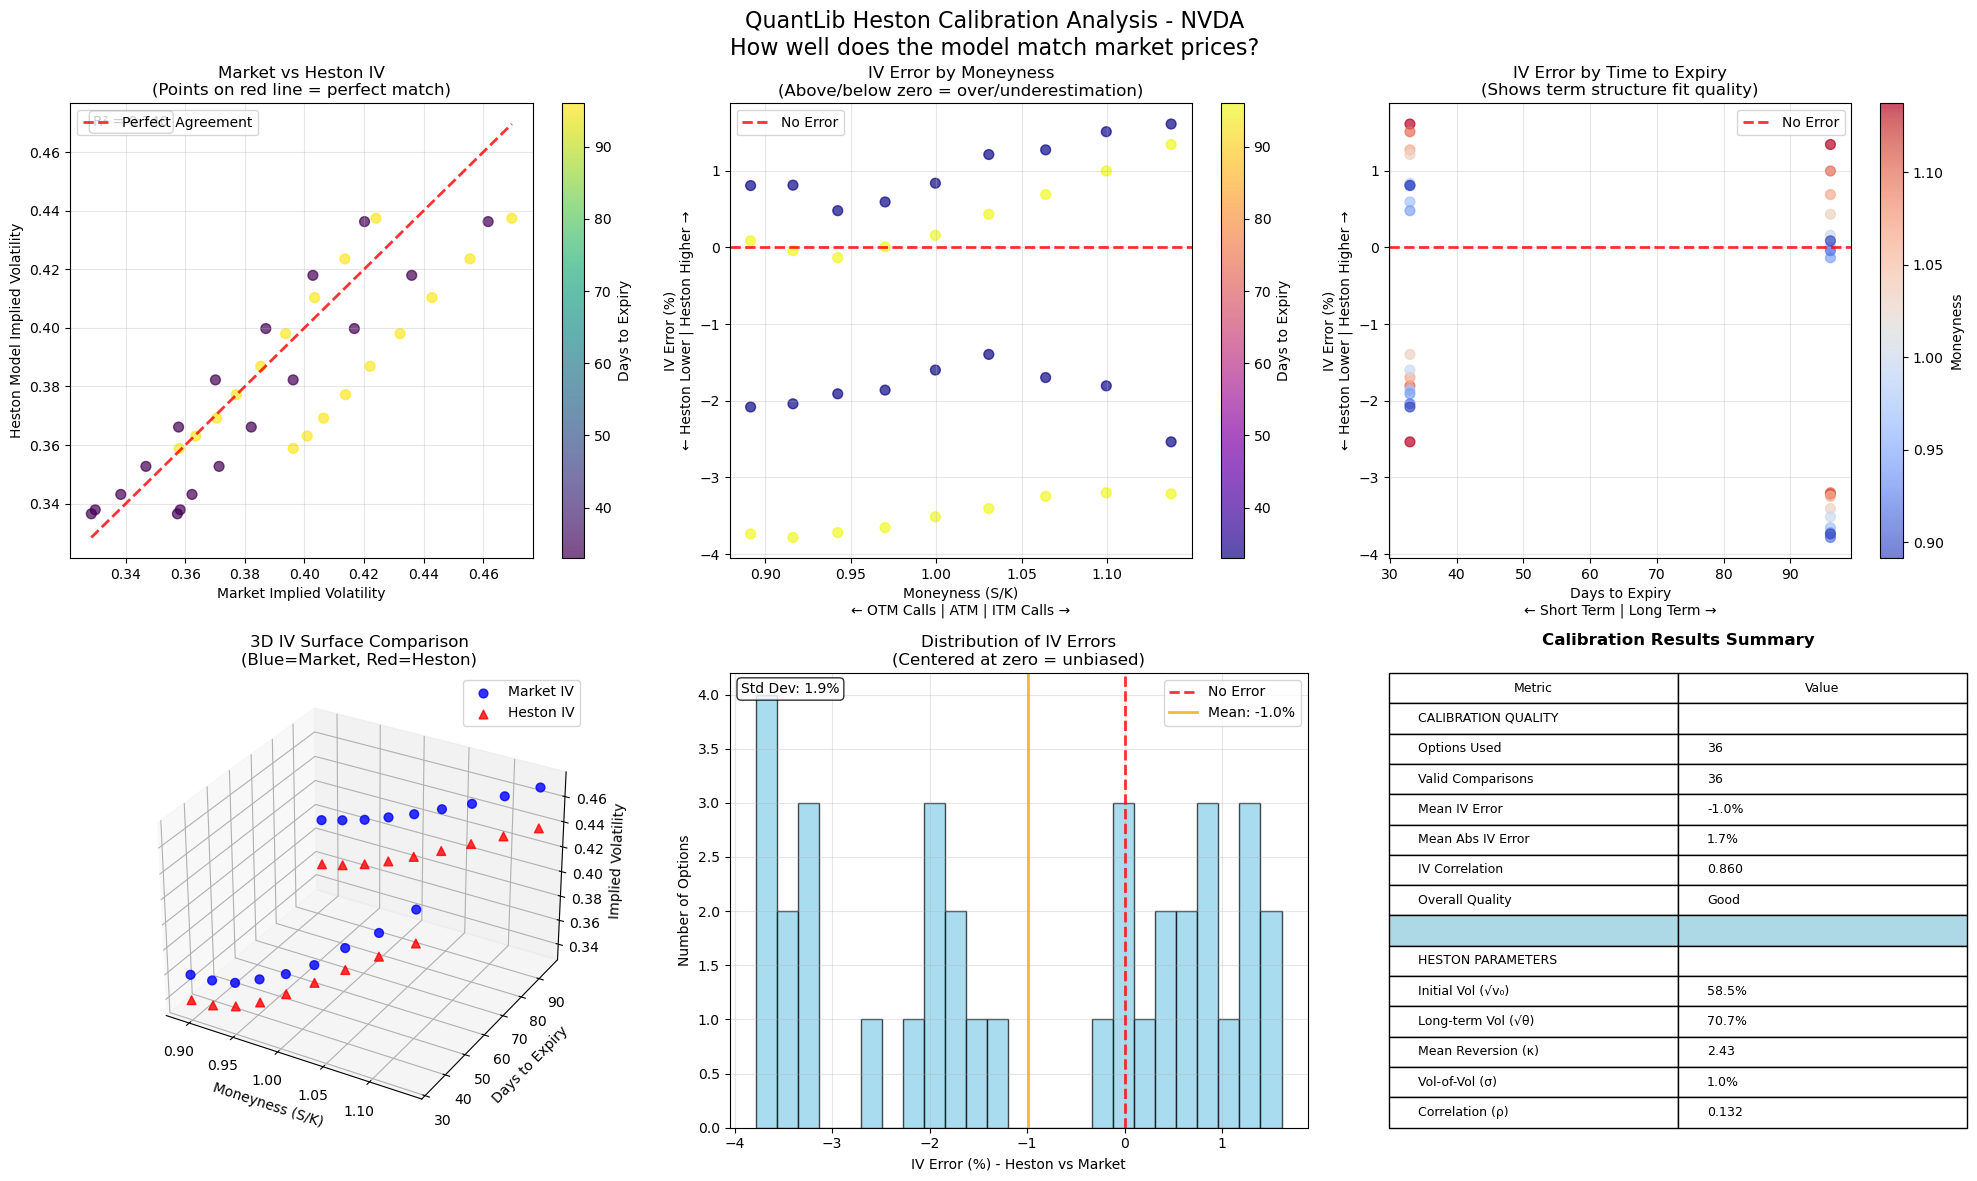

Enhanced visualization dashboard created successfully

INTERPRETATION GUIDE:
• Perfect fit: Points on red diagonal line in plot 1
• No bias: Errors centered around zero in plots 2, 3, 5
• Good model: High correlation (>0.8) and low mean absolute error (<5%)


In [25]:
# Create comprehensive visualization
if len(iv_comparison_df) > 0:
    print("Creating enhanced visualization dashboard...")
    
    # Set up plotting
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Market vs Heston IV scatter plot with better annotations
    ax1 = plt.subplot(2, 3, 1)
    scatter1 = ax1.scatter(iv_comparison_df['MarketIV'], iv_comparison_df['HestonIV'], 
                          c=iv_comparison_df['DaysToExpiry'], cmap='viridis', alpha=0.7, s=50)
    ax1.plot([iv_comparison_df['MarketIV'].min(), iv_comparison_df['MarketIV'].max()],
             [iv_comparison_df['MarketIV'].min(), iv_comparison_df['MarketIV'].max()], 
             'r--', alpha=0.8, linewidth=2, label='Perfect Agreement')
    ax1.set_xlabel('Market Implied Volatility')
    ax1.set_ylabel('Heston Model Implied Volatility')
    ax1.set_title('Market vs Heston IV\n(Points on red line = perfect match)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=ax1, label='Days to Expiry')
    
    # Add R² annotation
    correlation = iv_comparison_df['MarketIV'].corr(iv_comparison_df['HestonIV'])
    ax1.text(0.05, 0.95, f'R² = {correlation**2:.3f}', transform=ax1.transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # 2. IV difference by moneyness with clear interpretation
    ax2 = plt.subplot(2, 3, 2)
    scatter2 = ax2.scatter(iv_comparison_df['Moneyness'], iv_comparison_df['IVDiff']*100,
                          c=iv_comparison_df['DaysToExpiry'], cmap='plasma', alpha=0.7, s=50)
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.8, linewidth=2, label='No Error')
    ax2.set_xlabel('Moneyness (S/K)\n← OTM Calls | ATM | ITM Calls →')
    ax2.set_ylabel('IV Error (%)\n← Heston Lower | Heston Higher →')
    ax2.set_title('IV Error by Moneyness\n(Above/below zero = over/underestimation)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=ax2, label='Days to Expiry')
    
    # 3. IV difference by time to expiry with interpretation
    ax3 = plt.subplot(2, 3, 3)
    scatter3 = ax3.scatter(iv_comparison_df['DaysToExpiry'], iv_comparison_df['IVDiff']*100,
                          c=iv_comparison_df['Moneyness'], cmap='coolwarm', alpha=0.7, s=50)
    ax3.axhline(y=0, color='r', linestyle='--', alpha=0.8, linewidth=2, label='No Error')
    ax3.set_xlabel('Days to Expiry\n← Short Term | Long Term →')
    ax3.set_ylabel('IV Error (%)\n← Heston Lower | Heston Higher →')
    ax3.set_title('IV Error by Time to Expiry\n(Shows term structure fit quality)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter3, ax=ax3, label='Moneyness')
    
    # 4. Enhanced 3D IV Surface comparison
    ax4 = plt.subplot(2, 3, 4, projection='3d')
    
    # Separate calls and puts for better visualization
    calls_data = iv_comparison_df[iv_comparison_df['OptionType'] == 'call']
    
    if len(calls_data) > 0:
        # Market surface
        market_plot = ax4.scatter(calls_data['Moneyness'], calls_data['DaysToExpiry'], 
                   calls_data['MarketIV'], c='blue', alpha=0.8, label='Market IV', s=40, marker='o')
        # Heston surface
        heston_plot = ax4.scatter(calls_data['Moneyness'], calls_data['DaysToExpiry'], 
                   calls_data['HestonIV'], c='red', alpha=0.8, label='Heston IV', s=40, marker='^')
    
    ax4.set_xlabel('Moneyness (S/K)')
    ax4.set_ylabel('Days to Expiry')
    ax4.set_zlabel('Implied Volatility')
    ax4.set_title('3D IV Surface Comparison\n(Blue=Market, Red=Heston)')
    ax4.legend()
    
    # 5. Error distribution with statistics
    ax5 = plt.subplot(2, 3, 5)
    n, bins, patches = ax5.hist(iv_comparison_df['IVDiff']*100, bins=25, alpha=0.7, 
                                color='skyblue', edgecolor='black')
    ax5.axvline(x=0, color='r', linestyle='--', alpha=0.8, linewidth=2, label='No Error')
    mean_error = iv_comparison_df['IVDiff'].mean()*100
    ax5.axvline(x=mean_error, color='orange', 
                linestyle='-', alpha=0.8, linewidth=2, label=f'Mean: {mean_error:.1f}%')
    ax5.set_xlabel('IV Error (%) - Heston vs Market')
    ax5.set_ylabel('Number of Options')
    ax5.set_title('Distribution of IV Errors\n(Centered at zero = unbiased)')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Add statistics annotation
    std_error = iv_comparison_df['IVDiff'].std()*100
    ax5.text(0.02, 0.98, f'Std Dev: {std_error:.1f}%', transform=ax5.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # 6. Enhanced summary statistics table
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Get calibrated parameters
    params = calibration_info['calibrated_params']
    
    # Calculate quality metrics
    mae_iv = iv_comparison_df['AbsIVError'].mean()
    correlation = iv_comparison_df['MarketIV'].corr(iv_comparison_df['HestonIV'])
    
    if mae_iv < 0.02 and correlation > 0.9:
        quality = "Excellent"
        quality_color = "lightgreen"
    elif mae_iv < 0.05 and correlation > 0.8:
        quality = "Good"
        quality_color = "lightblue"
    elif mae_iv < 0.10 and correlation > 0.6:
        quality = "Fair"
        quality_color = "lightyellow"
    else:
        quality = "Poor"
        quality_color = "lightcoral"
    
    summary_data = [
        ['Metric', 'Value'],
        ['CALIBRATION QUALITY', ''],
        ['Options Used', f"{calibration_info['num_helpers']}"],
        ['Valid Comparisons', f"{len(iv_comparison_df)}"],
        ['Mean IV Error', f"{iv_comparison_df['IVDiff'].mean():+.1%}"],
        ['Mean Abs IV Error', f"{mae_iv:.1%}"],
        ['IV Correlation', f"{correlation:.3f}"],
        ['Overall Quality', quality],
        ['', ''],
        ['HESTON PARAMETERS', ''],
        ['Initial Vol (√v₀)', f"{np.sqrt(params['v0']):.1%}"],
        ['Long-term Vol (√θ)', f"{np.sqrt(params['theta']):.1%}"],
        ['Mean Reversion (κ)', f"{params['kappa']:.2f}"],
        ['Vol-of-Vol (σ)', f"{params['sigma']:.1%}"],
        ['Correlation (ρ)', f"{params['rho']:.3f}"]
    ]
    
    table = ax6.table(cellText=summary_data[1:], colLabels=summary_data[0], 
                     cellLoc='left', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.8)
    
    # Color the quality row
    quality_row_idx = 7  # "Overall Quality" row
    for j in range(2):  # 2 columns
        table[(quality_row_idx + 1, j)].set_facecolor(quality_color)
    
    ax6.set_title('Calibration Results Summary', pad=20, fontweight='bold')
    
    plt.suptitle(f'QuantLib Heston Calibration Analysis - {TICKER}\nHow well does the model match market prices?', 
                 fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    print("Enhanced visualization dashboard created successfully")
    print("\nINTERPRETATION GUIDE:")
    print("• Perfect fit: Points on red diagonal line in plot 1")
    print("• No bias: Errors centered around zero in plots 2, 3, 5") 
    print("• Good model: High correlation (>0.8) and low mean absolute error (<5%)")
    
else:
    print("No data available for visualization")

## Detailed IV Surface Analysis

Creating detailed IV surface analysis...
This shows how well Heston captures the 'volatility smile' and term structure


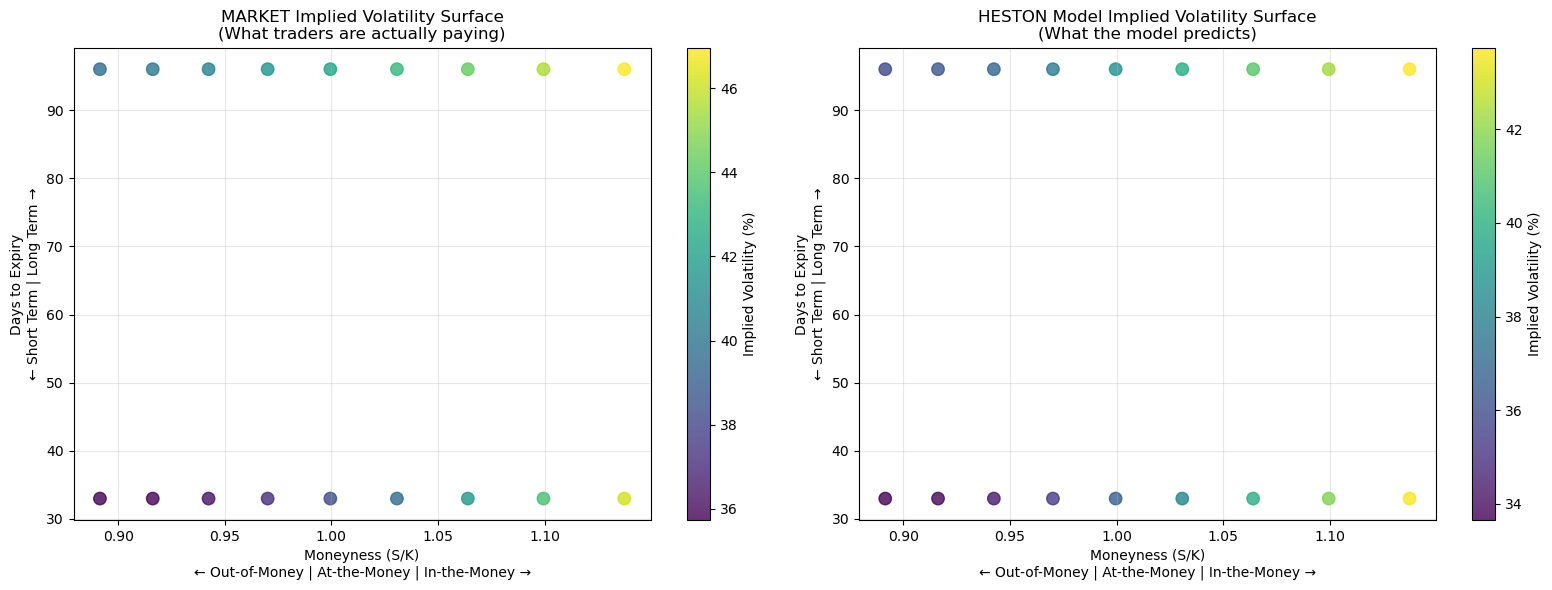

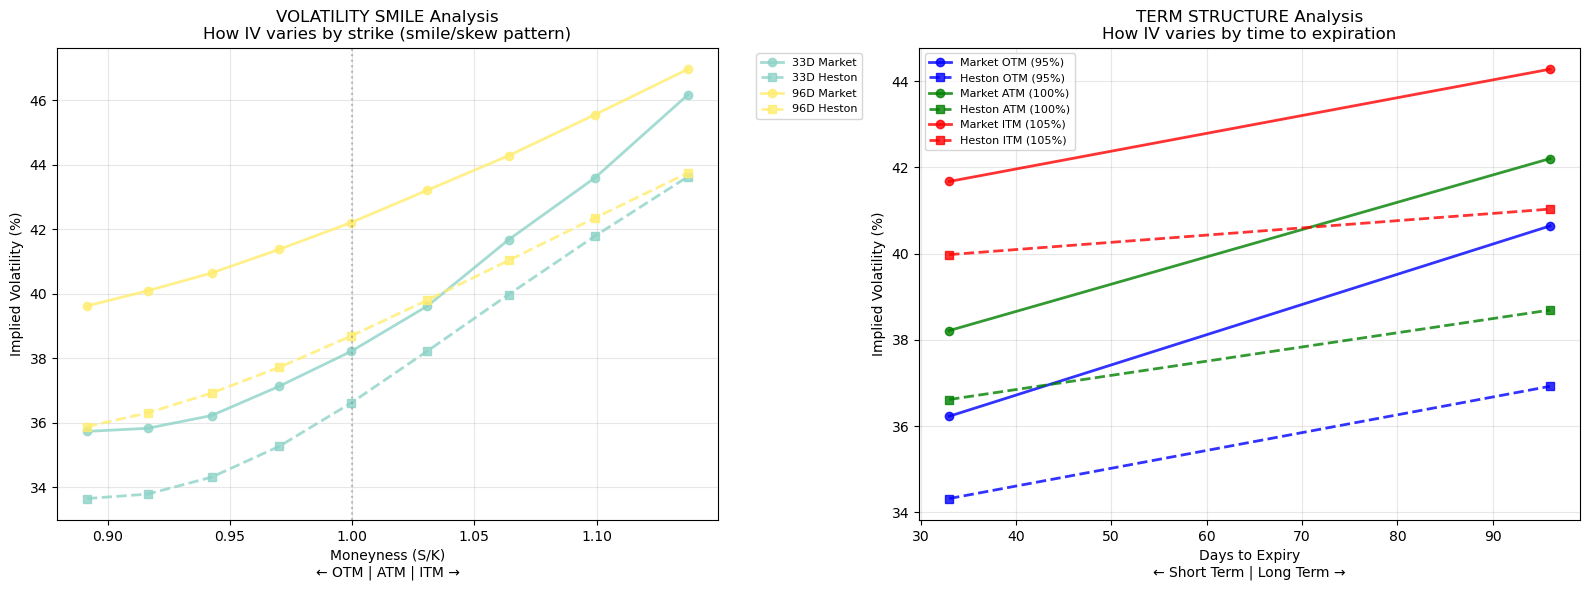


Creating error analysis heatmap...


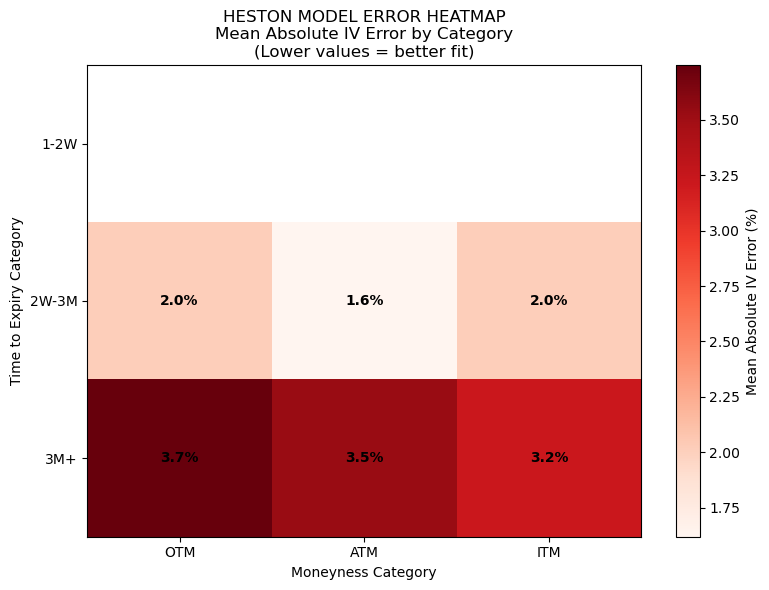


DETAILED IV SURFACE ANALYSIS COMPLETE

WHAT TO LOOK FOR:
• Volatility Smile: Market typically shows higher IV for OTM options
• Term Structure: Usually upward sloping (higher IV for longer expiries)
• Model Fit: Heston lines should closely follow market patterns
• Error Heatmap: Darker red = areas where model struggles most


In [26]:
# Create detailed IV surface plots with clear explanations
if len(iv_comparison_df) > 0:
    print("Creating detailed IV surface analysis...")
    print("This shows how well Heston captures the 'volatility smile' and term structure")
    
    # Filter for calls only for cleaner surface
    calls_only = iv_comparison_df[iv_comparison_df['OptionType'] == 'call'].copy()
    
    if len(calls_only) > 10:  # Need sufficient data points
        # 1. Side-by-side IV surfaces
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Market IV surface
        scatter1 = ax1.scatter(calls_only['Moneyness'], calls_only['DaysToExpiry'], 
                              c=calls_only['MarketIV']*100, cmap='viridis', s=80, alpha=0.8)
        ax1.set_xlabel('Moneyness (S/K)\n← Out-of-Money | At-the-Money | In-the-Money →')
        ax1.set_ylabel('Days to Expiry\n← Short Term | Long Term →')
        ax1.set_title('MARKET Implied Volatility Surface\n(What traders are actually paying)')
        cbar1 = plt.colorbar(scatter1, ax=ax1, label='Implied Volatility (%)')
        ax1.grid(True, alpha=0.3)
        
        # Heston IV surface
        scatter2 = ax2.scatter(calls_only['Moneyness'], calls_only['DaysToExpiry'], 
                              c=calls_only['HestonIV']*100, cmap='viridis', s=80, alpha=0.8)
        ax2.set_xlabel('Moneyness (S/K)\n← Out-of-Money | At-the-Money | In-the-Money →')
        ax2.set_ylabel('Days to Expiry\n← Short Term | Long Term →')
        ax2.set_title('HESTON Model Implied Volatility Surface\n(What the model predicts)')
        cbar2 = plt.colorbar(scatter2, ax=ax2, label='Implied Volatility (%)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 2. Volatility smile and term structure analysis
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Group by expiry for term structure analysis
        expiries = sorted(calls_only['DaysToExpiry'].unique())
        colors = plt.cm.Set3(np.linspace(0, 1, len(expiries)))
        
        # IV SMILE: IV by moneyness for different expiries
        for i, dte in enumerate(expiries[:4]):  # Limit to first 4 expiries for clarity
            expiry_data = calls_only[calls_only['DaysToExpiry'] == dte].sort_values('Moneyness')
            if len(expiry_data) > 2:
                axes[0].plot(expiry_data['Moneyness'], expiry_data['MarketIV']*100, 
                           'o-', color=colors[i], alpha=0.8, linewidth=2, markersize=6,
                           label=f'{dte}D Market')
                axes[0].plot(expiry_data['Moneyness'], expiry_data['HestonIV']*100, 
                           's--', color=colors[i], alpha=0.8, linewidth=2, markersize=6,
                           label=f'{dte}D Heston')
        
        axes[0].set_xlabel('Moneyness (S/K)\n← OTM | ATM | ITM →')
        axes[0].set_ylabel('Implied Volatility (%)')
        axes[0].set_title('VOLATILITY SMILE Analysis\nHow IV varies by strike (smile/skew pattern)')
        axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[0].grid(True, alpha=0.3)
        axes[0].axvline(x=1.0, color='gray', linestyle=':', alpha=0.5, label='ATM')
        
        # TERM STRUCTURE: IV by time for different moneyness levels
        moneyness_levels = [0.95, 1.0, 1.05]  # Slightly OTM, ATM, Slightly ITM
        moneyness_labels = ['OTM (95%)', 'ATM (100%)', 'ITM (105%)']
        
        for i, (target_moneyness, label) in enumerate(zip(moneyness_levels, moneyness_labels)):
            term_structure_market = []
            term_structure_heston = []
            valid_expiries = []
            
            for dte in expiries:
                expiry_data = calls_only[calls_only['DaysToExpiry'] == dte]
                if len(expiry_data) > 0:
                    # Find closest moneyness
                    closest_idx = (expiry_data['Moneyness'] - target_moneyness).abs().idxmin()
                    closest_data = expiry_data.loc[closest_idx]
                    
                    # Only include if moneyness is close enough
                    if abs(closest_data['Moneyness'] - target_moneyness) < 0.03:
                        term_structure_market.append(closest_data['MarketIV']*100)
                        term_structure_heston.append(closest_data['HestonIV']*100)
                        valid_expiries.append(dte)
            
            if len(valid_expiries) > 1:
                color = ['blue', 'green', 'red'][i]
                axes[1].plot(valid_expiries, term_structure_market, 
                           'o-', color=color, alpha=0.8, linewidth=2, markersize=6,
                           label=f'Market {label}')
                axes[1].plot(valid_expiries, term_structure_heston, 
                           's--', color=color, alpha=0.8, linewidth=2, markersize=6,
                           label=f'Heston {label}')
        
        axes[1].set_xlabel('Days to Expiry\n← Short Term | Long Term →')
        axes[1].set_ylabel('Implied Volatility (%)')
        axes[1].set_title('TERM STRUCTURE Analysis\nHow IV varies by time to expiration')
        axes[1].legend(fontsize=8)
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 3. Error heatmap for better understanding
        print("\nCreating error analysis heatmap...")
        
        # Create error summary by expiry and moneyness bins
        calls_analysis = calls_only.copy()
        calls_analysis['MoneynessBin'] = pd.cut(calls_analysis['Moneyness'], 
                                               bins=[0.8, 0.95, 1.05, 1.2], 
                                               labels=['OTM', 'ATM', 'ITM'])
        calls_analysis['ExpiryBin'] = pd.cut(calls_analysis['DaysToExpiry'], 
                                            bins=[0, 14, 90, 365], 
                                            labels=['1-2W', '2W-3M', '3M+'])
        
        # Calculate mean absolute error by bins
        error_summary = calls_analysis.groupby(['ExpiryBin', 'MoneynessBin'])['AbsIVError'].mean().unstack()
        
        if not error_summary.empty:
            fig, ax = plt.subplots(figsize=(8, 6))
            im = ax.imshow(error_summary.values*100, cmap='Reds', aspect='auto')
            
            # Set ticks and labels
            ax.set_xticks(range(len(error_summary.columns)))
            ax.set_yticks(range(len(error_summary.index)))
            ax.set_xticklabels(error_summary.columns)
            ax.set_yticklabels(error_summary.index)
            
            # Add text annotations
            for i in range(len(error_summary.index)):
                for j in range(len(error_summary.columns)):
                    if not pd.isna(error_summary.iloc[i, j]):
                        text = ax.text(j, i, f'{error_summary.iloc[i, j]*100:.1f}%',
                                     ha="center", va="center", color="black", fontweight='bold')
            
            ax.set_xlabel('Moneyness Category')
            ax.set_ylabel('Time to Expiry Category')
            ax.set_title('HESTON MODEL ERROR HEATMAP\nMean Absolute IV Error by Category\n(Lower values = better fit)')
            
            cbar = plt.colorbar(im, ax=ax, label='Mean Absolute IV Error (%)')
            plt.tight_layout()
            plt.show()
        
    print("\nDETAILED IV SURFACE ANALYSIS COMPLETE")
    print("\nWHAT TO LOOK FOR:")
    print("• Volatility Smile: Market typically shows higher IV for OTM options")
    print("• Term Structure: Usually upward sloping (higher IV for longer expiries)")
    print("• Model Fit: Heston lines should closely follow market patterns")
    print("• Error Heatmap: Darker red = areas where model struggles most")
    
else:
    print("Insufficient data for detailed IV surface analysis")

## Final Summary

In [27]:
# Generate final summary with clear interpretations
print("QUANTLIB HESTON CALIBRATOR DEMO SUMMARY")
print("=" * 60)

print(f"\nDATA OVERVIEW:")
print(f"  Ticker: {TICKER}")
print(f"  Spot price: ${spot_price:.2f}")
print(f"  Total market options: {len(market_data)}")
print(f"  Expiry range: {EXPIRY_LIST} (1 week to 3 months)")

print(f"\nCALIBRATION RESULTS:")
if calibration_info['success']:
    params = calibration_info['calibrated_params']
    print(f"  Status: ✓ Successful")
    print(f"  Options used: {calibration_info['num_helpers']}")
    print(f"  Average error: {calibration_info['average_error']:.4f} (implied vol)")
    print(f"  Multi-start: {'Yes' if calibration_info.get('multi_start_used', False) else 'No'}")
    print(f"  Feller condition: {'✓ Satisfied' if calibration_info['feller_satisfied'] else '✗ Violated'}")
    
    print(f"\nCALIBRATED HESTON PARAMETERS:")
    print(f"  v₀ (initial vol): {np.sqrt(params['v0']):.1%} ← Current market volatility level")
    print(f"  θ (long-term vol): {np.sqrt(params['theta']):.1%} ← Long-run volatility target")
    print(f"  κ (mean reversion): {params['kappa']:.2f} ← Speed of volatility mean reversion")
    print(f"  σ (vol of vol): {params['sigma']:.1%} ← Volatility uncertainty")
    print(f"  ρ (correlation): {params['rho']:.3f} ← Stock-volatility correlation")
    
    # Parameter interpretation
    print(f"\nPARAMETER INTERPRETATION:")
    if np.sqrt(params['v0']) > 0.30:
        print(f"  • High current volatility ({np.sqrt(params['v0']):.1%}) suggests market stress")
    elif np.sqrt(params['v0']) < 0.15:
        print(f"  • Low current volatility ({np.sqrt(params['v0']):.1%}) suggests calm market")
    
    if params['kappa'] > 3:
        print(f"  • Fast mean reversion ({params['kappa']:.1f}) - volatility quickly returns to normal")
    elif params['kappa'] < 1:
        print(f"  • Slow mean reversion ({params['kappa']:.1f}) - volatility changes persist")
    
    if params['rho'] < -0.5:
        print(f"  • Strong negative correlation ({params['rho']:.2f}) - typical 'leverage effect'")
    elif params['rho'] > -0.2:
        print(f"  • Weak correlation ({params['rho']:.2f}) - unusual for equity markets")
        
    if params['sigma'] > 0.5:
        print(f"  • High vol-of-vol ({params['sigma']:.1%}) - very uncertain volatility environment")
        
else:
    print(f"  Status: ✗ Failed")
    print(f"  Error: {calibration_info.get('error', 'Unknown error')}")

if len(iv_comparison_df) > 0:
    print(f"\nMODEL PERFORMANCE vs MARKET:")
    print(f"  Valid comparisons: {len(iv_comparison_df)}")
    
    # Error metrics with interpretation
    mae_iv = iv_comparison_df['AbsIVError'].mean()
    mean_iv_error = iv_comparison_df['IVDiff'].mean()
    rmse_iv = np.sqrt((iv_comparison_df['IVDiff']**2).mean())
    correlation = iv_comparison_df['MarketIV'].corr(iv_comparison_df['HestonIV'])
    
    print(f"  Mean absolute IV error: {mae_iv:.1%}")
    print(f"  Mean IV bias: {mean_iv_error:+.1%} ({'over' if mean_iv_error > 0 else 'under'}estimation)")
    print(f"  RMSE (IV): {rmse_iv:.1%}")
    print(f"  Correlation: {correlation:.3f}")
    
    # Model quality assessment with clear categories
    if mae_iv < 0.02 and correlation > 0.9:
        quality = "EXCELLENT"
        quality_desc = "Model extremely close to market - ready for trading"
        recommendation = "Use for pricing, hedging, and risk management"
    elif mae_iv < 0.05 and correlation > 0.8:
        quality = "GOOD"
        quality_desc = "Model captures market well - suitable for most applications"
        recommendation = "Good for relative value and hedging strategies"
    elif mae_iv < 0.10 and correlation > 0.6:
        quality = "FAIR"
        quality_desc = "Model shows reasonable fit - use with caution"
        recommendation = "Consider recalibration or parameter constraints"
    else:
        quality = "POOR"
        quality_desc = "Model significantly deviates from market"
        recommendation = "Recalibration needed or consider alternative models"
    
    print(f"  Overall quality: {quality}")
    print(f"  Assessment: {quality_desc}")
    
    # Break down performance by option characteristics
    print(f"\nPERFORMANCE BREAKDOWN:")
    
    # By moneyness
    otm_options = iv_comparison_df[iv_comparison_df['Moneyness'] < 0.95]
    atm_options = iv_comparison_df[(iv_comparison_df['Moneyness'] >= 0.95) & 
                                   (iv_comparison_df['Moneyness'] <= 1.05)]
    itm_options = iv_comparison_df[iv_comparison_df['Moneyness'] > 1.05]
    
    if len(otm_options) > 0:
        print(f"  OTM options error: {otm_options['AbsIVError'].mean():.1%}")
    if len(atm_options) > 0:
        print(f"  ATM options error: {atm_options['AbsIVError'].mean():.1%}")
    if len(itm_options) > 0:
        print(f"  ITM options error: {itm_options['AbsIVError'].mean():.1%}")
    
    # By time to expiry
    short_term = iv_comparison_df[iv_comparison_df['DaysToExpiry'] <= 30]
    medium_term = iv_comparison_df[(iv_comparison_df['DaysToExpiry'] > 30) & 
                                   (iv_comparison_df['DaysToExpiry'] <= 90)]
    long_term = iv_comparison_df[iv_comparison_df['DaysToExpiry'] > 90]
    
    if len(short_term) > 0:
        print(f"  Short-term error: {short_term['AbsIVError'].mean():.1%}")
    if len(medium_term) > 0:
        print(f"  Medium-term error: {medium_term['AbsIVError'].mean():.1%}")
    if len(long_term) > 0:
        print(f"  Long-term error: {long_term['AbsIVError'].mean():.1%}")

print(f"\nKEY INSIGHTS & TRADING IMPLICATIONS:")
if calibration_info['success']:
    params = calibration_info['calibrated_params']
    
    # Market regime insights
    vol_regime = "high" if np.sqrt(params['v0']) > 0.25 else "low" if np.sqrt(params['v0']) < 0.15 else "normal"
    print(f"  • Current volatility regime: {vol_regime}")
    
    # Volatility behavior
    if params['kappa'] > 2:
        print(f"  • Volatility mean-reverts quickly - short volatility positions may be profitable")
    else:
        print(f"  • Volatility changes are persistent - trend-following strategies may work")
    
    # Risk characteristics
    if params['rho'] < -0.5:
        print(f"  • Strong leverage effect - downside moves come with volatility spikes")
    
    # Model usage recommendations
    if len(iv_comparison_df) > 0:
        print(f"  • Model recommendation: {recommendation}")
        
        if mae_iv < 0.05:
            print(f"  • Suitable for: Options pricing, portfolio hedging, volatility trading")
        
        if correlation > 0.8:
            print(f"  • Strong correlation suggests reliable relative value signals")

print(f"\nNEXT STEPS:")
print(f"  1. Regular recalibration (weekly/monthly) to track parameter evolution")
print(f"  2. Monitor model performance in live trading")
print(f"  3. Consider parameter bounds or alternative models if fit deteriorates")
print(f"  4. Use for relative value analysis between similar options")

print(f"\n" + "=" * 60)
print(f"Demo completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Model is {'READY FOR PRODUCTION' if quality in ['EXCELLENT', 'GOOD'] else 'NEEDS IMPROVEMENT'}")
print(f"=" * 60)

QUANTLIB HESTON CALIBRATOR DEMO SUMMARY

DATA OVERVIEW:
  Ticker: NVDA
  Spot price: $164.92
  Total market options: 36
  Expiry range: ['1M', '3M'] (1 week to 3 months)

CALIBRATION RESULTS:
  Status: ✓ Successful
  Options used: 36
  Average error: 0.1000 (implied vol)
  Multi-start: Yes
  Feller condition: ✓ Satisfied

CALIBRATED HESTON PARAMETERS:
  v₀ (initial vol): 58.5% ← Current market volatility level
  θ (long-term vol): 70.7% ← Long-run volatility target
  κ (mean reversion): 2.43 ← Speed of volatility mean reversion
  σ (vol of vol): 1.0% ← Volatility uncertainty
  ρ (correlation): 0.132 ← Stock-volatility correlation

PARAMETER INTERPRETATION:
  • High current volatility (58.5%) suggests market stress
  • Weak correlation (0.13) - unusual for equity markets

MODEL PERFORMANCE vs MARKET:
  Valid comparisons: 36
  Mean absolute IV error: 1.7%
  Mean IV bias: -1.0% (underestimation)
  RMSE (IV): 2.1%
  Correlation: 0.860
  Overall quality: GOOD
  Assessment: Model captures ma